In [2]:
pip install git+https://github.com/dbouget/raidionics_rads_lib.git

  Cloning https://github.com/dbouget/raidionics_rads_lib.git to /home/dbouget/.tmp/pip-req-build-7ymrd62m
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_rads_lib.git /home/dbouget/.tmp/pip-req-build-7ymrd62m
  Resolved https://github.com/dbouget/raidionics_rads_lib.git to commit b9fd6d9e3d26719c80bdf2535272949bc34b8515
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/dbouget/raidionics_seg_lib.git (to revision master) to /home/dbouget/.tmp/pip-install-zz1b00di/raidionicsseg_bddfb60733504dad88e032d2898f7034
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/raidionics_seg_lib.git /home/dbouget/.tmp/pip-install-zz1b00di/raidionicsseg_bddfb60733504dad88e032d2898f7034
  Resolved https://github.com/dbouget/raidionics_seg_lib.git to commit 3d9d150426d8cae17ff8636fe3fe662693a37391
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━

In [10]:
#Download the test data
import os
import requests
import zipfile

test_image_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsRADSLib-UnitTest1.zip'
brain_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_Brain-ONNX-v12.zip'
seq_model_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Raidionics-MRI_Sequence_Classifier-ONNX-v12.zip'

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)
patient_dir = os.path.join(test_dir, 'patient')
models_dir = os.path.join(test_dir, 'models')
results_dir = os.path.join(test_dir, 'results')
os.makedirs(patient_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

archive_dl_dest = os.path.join(test_dir, 'inference_patient.zip')
headers = {}
response = requests.get(test_image_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

archive_dl_dest = os.path.join(test_dir, 'seq-model.zip')
headers = {}
response = requests.get(seq_model_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(models_dir)
            
archive_dl_dest = os.path.join(test_dir, 'brain-model.zip')
headers = {}
response = requests.get(brain_model_url, headers=headers, stream=True)
response.raise_for_status()
if response.status_code == requests.codes.ok:
    with open(archive_dl_dest, "wb") as f:
        for chunk in response.iter_content(chunk_size=1048576):
            f.write(chunk)
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(models_dir)


In [12]:
# Prepare the configuration file
import configparser
import json
import logging

logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)
rads_config = configparser.ConfigParser()
rads_config.add_section('Default')
rads_config.set('Default', 'task', 'neuro_diagnosis')
rads_config.set('Default', 'caller', '')
rads_config.add_section('System')
rads_config.set('System', 'gpu_id', "-1")
rads_config.set('System', 'input_folder', patient_dir)
rads_config.set('System', 'output_folder', results_dir)
rads_config.set('System', 'model_folder', models_dir)
rads_config.set('System', 'pipeline_filename', os.path.join(test_dir, 'test_pipeline.json'))
rads_config.add_section('Runtime')
rads_config.set('Runtime', 'reconstruction_method', 'thresholding')
rads_config.set('Runtime', 'reconstruction_order', 'resample_first')
rads_config_filename = os.path.join(results_dir, 'rads_config.ini')
with open(rads_config_filename, 'w') as outfile:
    rads_config.write(outfile)

# Prepare the underlying pipeline
pipeline_json = {}
step_index = 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Classification"
pipeline_json[step_str]["inputs"] = {}  # Empty input means running it on all existing data for the patient
pipeline_json[step_str]["model"] = "MRI_Sequence_Classifier"
pipeline_json[step_str]["description"] = "Classification of the MRI sequence type for all input scans."

step_index = step_index + 1
step_str = str(step_index)
pipeline_json[step_str] = {}
pipeline_json[step_str]["task"] = "Segmentation"
pipeline_json[step_str]["inputs"] = {}
pipeline_json[step_str]["inputs"]["0"] = {}
pipeline_json[step_str]["inputs"]["0"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["sequence"] = "T1-CE"
pipeline_json[step_str]["inputs"]["0"]["labels"] = None
pipeline_json[step_str]["inputs"]["0"]["space"] = {}
pipeline_json[step_str]["inputs"]["0"]["space"]["timestamp"] = 0
pipeline_json[step_str]["inputs"]["0"]["space"]["sequence"] = "T1-CE"
pipeline_json[step_str]["target"] = "Brain"
pipeline_json[step_str]["model"] = "MRI_Brain"
pipeline_json[step_str]["format"] = "thresholding"
pipeline_json[step_str]["description"] = "Brain segmentation in T1-CE (T0)."

with open(os.path.join(test_dir, 'test_pipeline.json'), 'w', newline='\n') as outfile:
    json.dump(pipeline_json, outfile, indent=4, sort_keys=True)

# Run the segmentation task
from raidionicsrads.compute import run_rads
run_rads(rads_config_filename)


INFO:root:Starting pipeline for file: /home/dbouget/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/test_pipeline.json.
INFO:root:LOG: Pipeline - 2 steps.
INFO:root:LOG: Pipeline - Classification of the MRI sequence type for all input scans. - Begin (1/2)
INFO:root:Starting inference for folder: inputs, with model: /home/dbouget/Code/Private/raidionics_rads_lib/notebooks/unit_tests_results_dir/models/MRI_Sequence_Classifier.
INFO:root:LOG: Classification - 3 steps.
INFO:root:LOG: Classification - Preprocessing - Begin (1/3)
DEBUG:root:Preprocessing - Extracting input data.
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
DEBUG:root:Preprocessing - Resampling.
DEBUG:root:Preprocessing - Background clipping.
DEBUG:root:MRI background cropping with: [14, 18, 46, 194, 222, 228].

DEBUG:root:Preprocessing - Volume resizing.
DEBUG:root:Preprocessing - Intensity normalization.


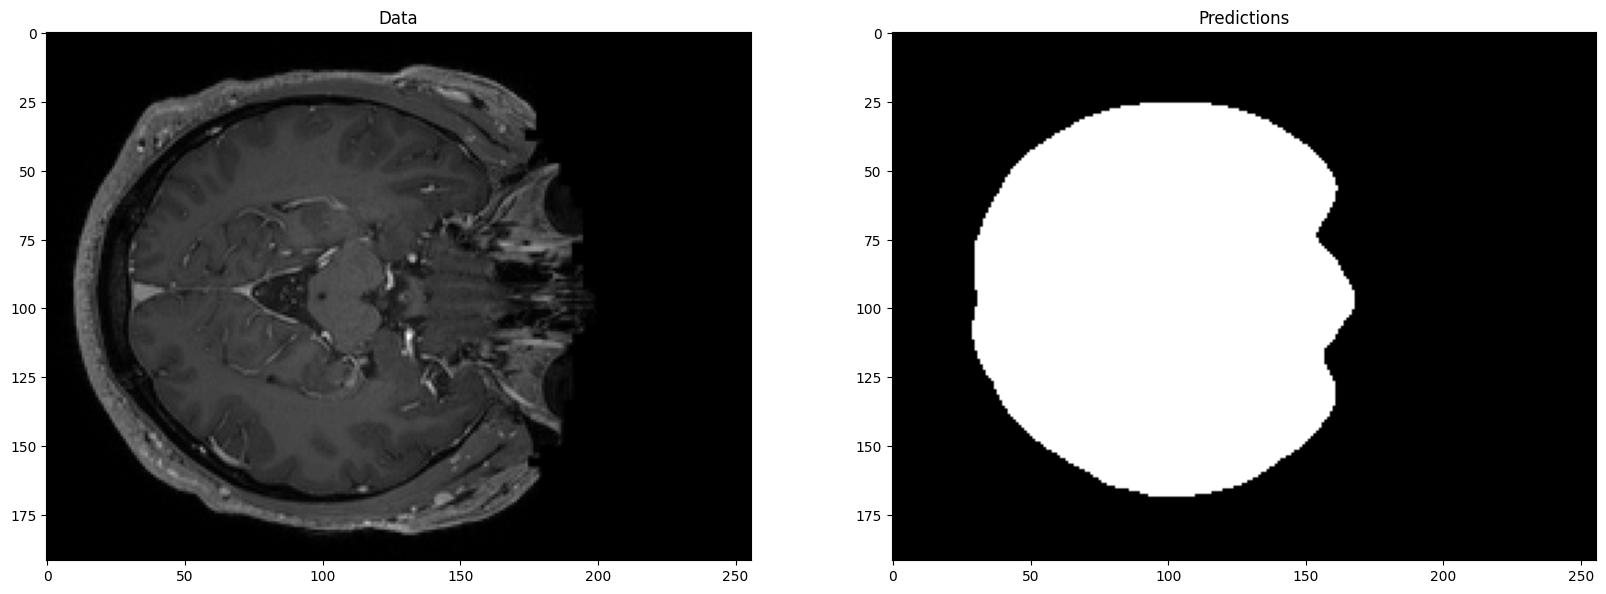

In [16]:
# Inspect the results
import nibabel as nib
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)
data_filename = os.path.join(patient_dir, 'T0', 'input1.nii.gz')
predictions_filename = os.path.join(results_dir, 'T0', 'input1_annotation-Brain.nii.gz')

data = nib.load(data_filename).get_fdata()[:]
predictions = nib.load(predictions_filename).get_fdata()[:]

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

# plot corresponding data and predictions for a single 2D slice
slice_nr = 120
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(data[..., slice_nr], cmap="gray")
ax[1].imshow(predictions[..., slice_nr], cmap="gray")

for i, title in enumerate(["Data", "Predictions"]):
  ax[i].set_title(title)
plt.show()